# DS 2023: Communicating with Data
## Final Project, Notebook B: Data Exploration
### Cameron Berryman - kqe6rf

1. Preliminary visualizations of single and multiple features.
2. Data transformations for various plots, e.g. wide tables for heatmaps.
3. Experiments with different plot types.

### Setup

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import datetime
import re
import math
import matplotlib.font_manager as fm

In [2]:
# Data setup
WORDLE = pd.read_csv('../data/wordledata.csv').set_index('puzzle_id').sort_index()
WORDLE['puzzle_date'] = pd.to_datetime(WORDLE['puzzle_date'], format="%m/%d/%Y")
WORDLE['word_first_use'] = pd.to_numeric(WORDLE['word_first_use'])
WORDLE['word_etymology'] = WORDLE['word_etymology'].str.lower()
WORDLE.head()

,puzzle_date,puzzle_answer,word_first_use,word_etymology,word_year_accurate
puzzle_id,,,,,
0,2021-06-19,CIGAR,1730,spanish cigarro,True
1,2021-06-20,REBUT,1300,"middle english, from anglo-french reboter , fr...",False
2,2021-06-21,SISSY,1879,sis,True
3,2021-06-22,HUMPH,1803,imitative of a grunt,True
4,2021-06-23,AWAKE,1100,middle english awaken (from old english awacan...,False


My main goal with this project is to measure rates of occurrence from etymology data. I want to classify languages based on groupings by region and language.

In [34]:
# This dictionary has the language groupings that are actually in the etymology data.
# Keys are language groups and values are languages/dialects.
top_class = {
    "modern_english" : ["early modern english", "modern english"],
    "obsolete_english" : ["old english", "middle english"],
    "latin" : ["medieval latin", "late latin", "vulgar latin", "latin"],
    "french" : ["french", "anglo-french", "gallo-romance", "picard"],
    "iberia" : ["spanish", "portuguese"],
    "italian" : ["italian"],
    "american_european_non_english" : ["american spanish", "american french"],
    "native_american" : ["ojibwa", "inuit", "algonquian", "choctaw", "quechua", "nahuatl", "tupi"],
    "german" : ["german", "old saxon"],
    "dutch" : ["dutch", "old low franconian"],
    "norse" : ["old norse", "norse", "norwegian", "nynorsk", "finnish"],
    "other_germanic" : ["frisian", "yiddish", "gothic"],
    "afroasiatic_middle_east" : ["persian", "hebrew", "arabic", "sanskrit", "akkadian", "semitic"],
    "greek" : ["greek", "ancient greek"],
    "slavic" : ["old church slavic", "balto-slavic", "russian", "polish", "czech", "bosnian-croatian-serbian"],
    "baltic" : ["lithuanian", "latvian", "prussian"],
    "celtic" : ["gaelic", "welsh", "irish", "scots", "breton"],
    "albanian" : ["albanian"],
    "armenian" : ["armenian"],
    "tocharian" : ["tocharian a", "tocharian b"],
    "western_asia" : ["turkish"],
    "south_central_asia" : ["hindi", "urdu", "dhivehi", "divehi"],
    "eastern_asia" : ["japanese", "malay"],
    "oceania" : ["tongan", "dharuk"]
}

# This dictionary gives more readable labels for the keys of the previous dictionary.
top_class_better_names = {
    "modern_english" : "Modern English (Post-1450)",
    "obsolete_english" : "Middle and Old English",
    "latin" : "Latin Variants",
    "french" : "French & French Dialects",
    "iberia" : "Spanish & Portuguese",
    "italian" : "Italian",
    "american_european_non_english" : "European Dialects in the Americas",
    "native_american" : "Native American Languages",
    "german" : "German",
    "dutch" : "Dutch",
    "norse" : "Old & Modern Norse",
    "other_germanic" : "Other Germanic Languages",
    "afroasiatic_middle_east" : "Afroasiatic & Semitic Languages",
    "greek" : "Modern & Ancient Greek",
    "slavic" : "Slavic Languages",
    "baltic" : "Baltic Languages",
    "celtic" : "Celtic Languages",
    "albanian" : "Albanian",
    "armenian" : "Armenian",
    "tocharian" : "Tocharian A & B",
    "western_asia" : "Turkish",
    "south_central_asia" : "South & Central Asian Languages",
    "eastern_asia" : "Japanese & Malay",
    "oceania" : "Tongan & Aboriginal Australian"}

# This dictionary groups the language families into more general regions so they can be plotted more effectively.
# Keys are families/regions and values are language groupings from the first dictionary.
lang_areas = {
    "Germanic" : ["obsolete_english", "german", "dutch", "norse", "other_germanic"],
    "Italic" : ["iberia", "latin", "french", "italian"],
    "Celtic" : ["celtic"],
    "Americas" : ["american_european_non_english", "native_american", "modern_english"],
    "Eastern Europe" : ["slavic", "baltic", "albanian", "armenian", "greek"],
    "Afroasiatic &\n Middle East" : ["afroasiatic_middle_east", "western_asia"],
    "Central Asia" : ["south_central_asia", "tocharian"],
    "Eastern Asia" : ["eastern_asia"], 
    "Oceania" : ["oceania"]

}


In [4]:
# This helper function extracts the useful data from categories that I found in viewing the data
def extract_origins(text):
    # Lowercase
    t = text.lower()

    # Remove parentheses, punctuation
    t = re.sub(r"[()\.,;:]", "", t)

    # Common origin patterns
    allpatterns = [pattern for patterns in top_class.values() for pattern in patterns]

    found = []
    for p in allpatterns:
        if re.search(p, t):
            found.append(p)

    if not found:
        return "unknown"

    return " ".join(found)

In [5]:
# This adds True to a column if a category is found in the etymology string.
def detect_categories(df, category_dict):
    result_df = pd.DataFrame(index=df.index)
    
    for category, keywords in category_dict.items():
        # Check if any keyword appears in DATA_STRIPPED for each row
        result_df[category] = df['etym_clean'].apply(
            lambda x: any(keyword.lower() in str(x).lower() for keyword in keywords)
        )
    
    return result_df


Before we go further, however, we need to filter out data that isn't helpful.
- Some Wordle answers were plurals of existing words. Merriam-Webster doesn't give origins for plural words and redirects to the singular word instead, so my tool didn't recognize any etymology data from that. Those all have year values of -1, so those need to be removed.

In [6]:
W_SING = WORDLE[WORDLE['word_first_use'] > -1]

In [ ]:
W_SING["etym_clean"] = W_SING["word_etymology"].apply(extract_origins)

/var/folders/2z/xwtc34f12y11jmjj71ct1jvw0000gp/T/ipykernel_83075/2556565891.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  W_SING["etym_clean"] = W_SING["word_etymology"].apply(extract_origins)


,puzzle_date,puzzle_answer,word_first_use,word_etymology,word_year_accurate
puzzle_id,,,,,
227,2022-02-01,THOSE,-1,"middle english, from those these, from old eng...",False


In [11]:
WORDLE_ALL = pd.concat([W_SING, detect_categories(W_SING, top_class)],axis=1)
WORDLE_ALL

,puzzle_date,puzzle_answer,word_first_use,word_etymology,word_year_accurate,etym_clean,modern_english,obsolete_english,latin,french,...,slavic,baltic,celtic,albanian,armenian,tocharian,western_asia,south_central_asia,eastern_asia,oceania
puzzle_id,,,,,,,,,,,,,,,,,,,,,
0,2021-06-19,CIGAR,1730,spanish cigarro,True,spanish,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2021-06-20,REBUT,1300,"middle english, from anglo-french reboter , fr...",False,middle english french anglo-french,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
2,2021-06-21,SISSY,1879,sis,True,unknown,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2021-06-22,HUMPH,1803,imitative of a grunt,True,unknown,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2021-06-23,AWAKE,1100,middle english awaken (from old english awacan...,False,old english middle english,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596,2025-11-01,MOTEL,1925,blend of motor and hotel,True,unknown,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1597,2025-11-02,RABID,1594,"latin rabidus mad, from rabere",True,latin,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1599,2025-11-04,VENUE,1531,"borrowed from anglo-french, probably alteratio...",True,vulgar latin latin french anglo-french,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False


Let's make some other data frames based on before New York Times bought Wordle.

In [12]:
def subset_by_time(df, start=None, end=None):
    if start is None and end is None:
        return df
    if start is not None and end is None:
        return df[df['puzzle_date'] >= start]
    elif start is None and end is not None:
        return df[df['puzzle_date'] <= end]
    elif start is not None and end is not None:
        return df[(df['puzzle_date'] >= start) & (df['puzzle_date'] <= end)]


In [13]:
WORDLE_PRE_NYT = subset_by_time(WORDLE_ALL, end=datetime(year=2022, month=1, day=31))
WORDLE_PRE_NYT.tail()

,puzzle_date,puzzle_answer,word_first_use,word_etymology,word_year_accurate,etym_clean,modern_english,obsolete_english,latin,french,...,slavic,baltic,celtic,albanian,armenian,tocharian,western_asia,south_central_asia,eastern_asia,oceania
puzzle_id,,,,,,,,,,,,,,,,,,,,,
221,2022-01-26,WHACK,1719,probably imitative of the sound of a blow,True,unknown,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
222,2022-01-27,MOUNT,1100,"middle english munt, mont, mount, in part goin...",False,old english middle english latin french anglo-...,False,True,True,True,...,False,False,True,False,False,False,False,False,False,False
223,2022-01-28,PERKY,1820,modern english,True,modern english,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
224,2022-01-29,COULD,1200,"middle english couthe, coude , from old englis...",False,old english middle english german,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
226,2022-01-31,LIGHT,1100,"middle english liht, light, going back to old ...",False,old english middle english latin german old sa...,False,True,True,False,...,True,True,True,False,True,True,False,False,False,False


In [14]:
WORDLE_POST_NYT = subset_by_time(WORDLE_ALL, start=datetime(year=2022, month=2, day=1))
WORDLE_POST_NYT.head()

,puzzle_date,puzzle_answer,word_first_use,word_etymology,word_year_accurate,etym_clean,modern_english,obsolete_english,latin,french,...,slavic,baltic,celtic,albanian,armenian,tocharian,western_asia,south_central_asia,eastern_asia,oceania
puzzle_id,,,,,,,,,,,,,,,,,,,,,
228,2022-02-02,MOIST,1300,"middle english moiste , from anglo-french, per...",False,middle english vulgar latin latin french anglo...,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
229,2022-02-03,SHARD,1100,"middle english, from old english sceard ; akin...",False,old english middle english,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
230,2022-02-04,PLEAT,1300,"middle english pleiten, derivative of playte, ...",False,middle english,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
231,2022-02-05,ALOFT,1200,"middle english, from old norse ā lopt , from ā...",False,middle english old norse norse,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
232,2022-02-06,SKILL,1200,"middle english skil , from old norse, distinct...",False,old english middle english old norse norse,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


Let's get an idea of proportions of how much of each language is in the data set.

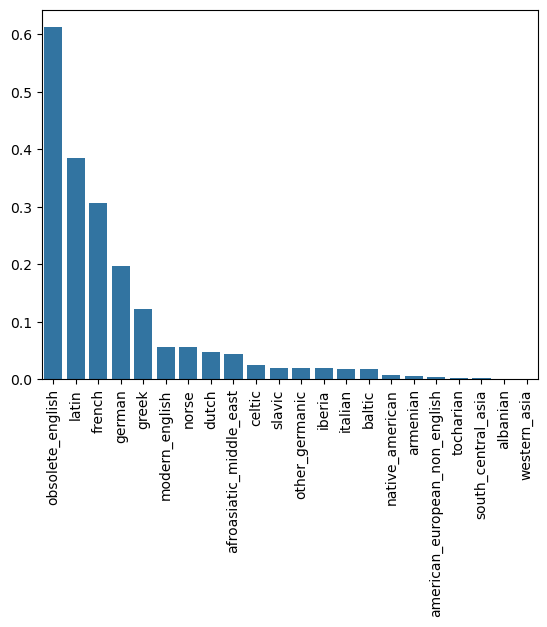

In [15]:
WORDLE_LANG = WORDLE_ALL.iloc[:, 6:(len(WORDLE_ALL.columns) - 2)]
sns.barplot((WORDLE_LANG.sum() / len(WORDLE_LANG)).sort_values(ascending=False))
plt.xticks(rotation=90)
plt.show()

Let's also see if there's a difference in proportions of origin between before New York Times bought the game and afterwards.

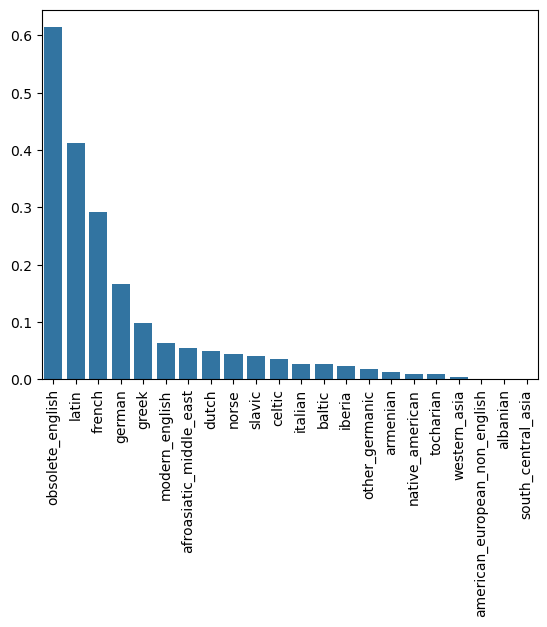

In [16]:
WORDLE_LANG_PRE_NYT = WORDLE_PRE_NYT.iloc[:, 6:(len(WORDLE_PRE_NYT.columns) - 2)]
sns.barplot((WORDLE_LANG_PRE_NYT.sum() / len(WORDLE_LANG_PRE_NYT)).sort_values(ascending=False))
plt.xticks(rotation=90)
plt.show()

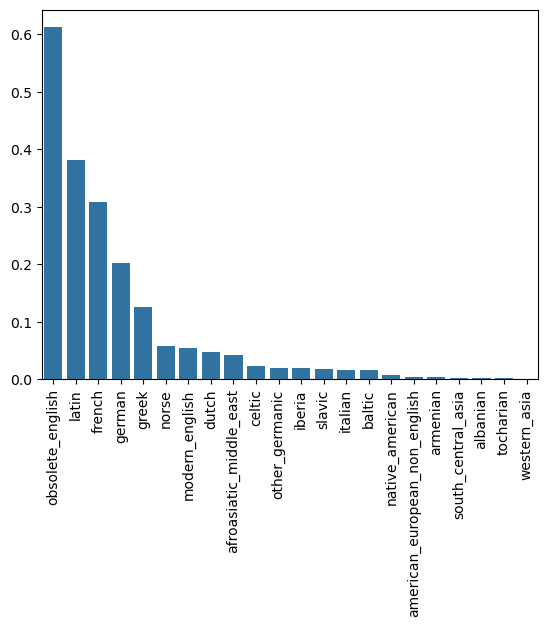

In [17]:
WORDLE_LANG_POST_NYT = WORDLE_POST_NYT.iloc[:, 6:(len(WORDLE_POST_NYT.columns) - 2)]
sns.barplot((WORDLE_LANG_POST_NYT.sum() / len(WORDLE_LANG_POST_NYT)).sort_values(ascending=False))
plt.xticks(rotation=90)
plt.show()

Regardless of timeframe, there is an inordinate amount of English and Latin. Not terribly surprising, considering this is a game in English. There also doesn't seem to be a major difference in proportion in language between pre-purchase by New York Times and after the purchase. The differences appear to be minor since the number of values from the more minor languages were so small. Not terribly interesting data. I probably won't include the difference between time periods in my final product.

Let's try and measure the coincidence of each category.
- Of the data that either category is true, what's the proportion that the other is true?
- Of the data that one category is true, what's the proportion that another is true?
  - Let's make heatmaps of both.

In [18]:
def coincidence(c1, c2):
    subset = WORDLE_LANG[(WORDLE_LANG[c1] == True) | (WORDLE_LANG[c2] == True)]
    total = len(subset)
    sum = len(subset[(subset[c1] == True) & (subset[c2] == True)])
    return sum / total

In [19]:
def coincidence_oneway(c1, c2):
    subset = WORDLE_LANG[(WORDLE_LANG[c1] == True)]
    total = len(subset)
    sum = len(subset[(subset[c1] == True) & (subset[c2] == True)])
    return sum / total

In [20]:
cols_langs = WORDLE_LANG.columns
coincidence_mat = pd.DataFrame(index=[top_class_better_names[col] for col in cols_langs], columns=[top_class_better_names[col] for col in cols_langs], dtype=float)
for i in range(len(cols_langs)):
    for j in range(len(cols_langs)):
        coincidence_mat.iloc[i, j] = coincidence(cols_langs[i], cols_langs[j])

<Axes: >

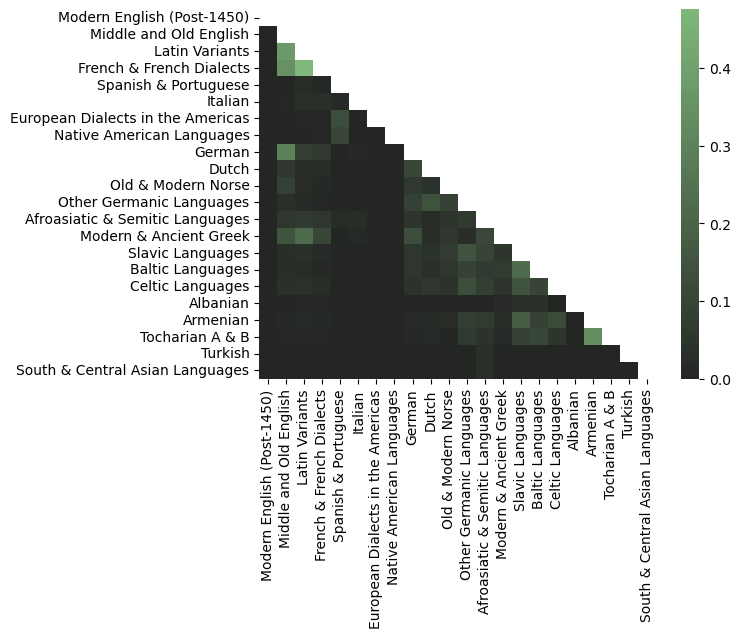

In [21]:
wordle_cmap = sns.dark_palette(color="#7fb87b", as_cmap=True)
masktri = np.triu(np.ones_like(coincidence_mat, dtype=bool))
sns.heatmap(coincidence_mat,cmap=wordle_cmap, mask=masktri)

Now one-way coincidence. I decided to pretty up the plots with more fitting colors and fonts according to the ones that the New York Times uses for Wordle.

In [32]:
fm.fontManager.addfont("../assets/fonts/Franklin Gothic Condensed.ttf")
plt.rcParams['font.family'] = 'Arial'

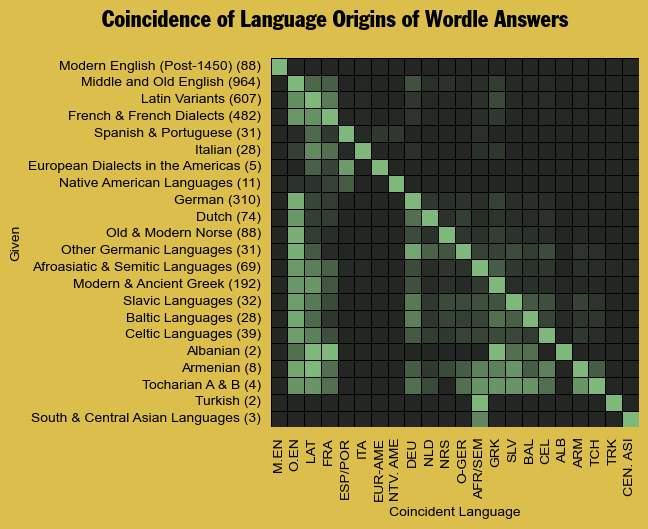

In [35]:
coincidence_mat2 = pd.DataFrame(index=[top_class_better_names[col] for col in cols_langs], columns=[top_class_better_names[col] for col in cols_langs], dtype=float)
for i in range(len(cols_langs)):
    for j in range(len(cols_langs)):
        coincidence_mat2.iloc[i, j] = coincidence_oneway(cols_langs[i], cols_langs[j])

counts = WORDLE_LANG.sum(axis=0)   # since columns are boolean, sum = count of True
new_labels = [f"{top_class_better_names[col]} ({counts[col]})" for col in cols_langs]
new_labels_nocounts = ["M.EN", "O.EN", "LAT", "FRA", "ESP/POR", "ITA", "EUR-AME", "NTV. AME", "DEU", "NLD", "NRS", 
                       "O-GER", "AFR/SEM", "GRK", "SLV", "BAL", "CEL", "ALB", "ARM", "TCH", "TRK", "CEN. ASI"]

ax = sns.heatmap(coincidence_mat2,cmap=wordle_cmap, linewidths=0.4, linecolor="black", cbar=False)
plt.suptitle("Coincidence of Language Origins of Wordle Answers", fontfamily="Franklin Gothic",fontsize=16, x=0.225)
plt.ylabel("Given")
plt.xlabel("Coincident Language")
ax.set_yticklabels(new_labels)
ax.set_xticklabels(new_labels_nocounts)
ax.tick_params(left=False,bottom=False)
plt.subplots_adjust(right=0.7)
plt.rcParams["figure.facecolor"] = "#dbbe4b"
plt.savefig("../assets/elementary_plots/wordle_heatmap.svg")

I like this one-way coincidence graph. I'll use this to show the relation between languages in my final product.

I used the code below to try and get more accurate language division categories. I discovered some pretty niche yet important cases in here, like Dharuk aboriginal Australian being a part of Oceanian languages.

In [29]:
WORDLE_NONE_MATCH = WORDLE_ALL[~(WORDLE_ALL.iloc[:, 6:].any(axis=1))]
WORDLE_NONE_MATCH = WORDLE_NONE_MATCH[WORDLE_NONE_MATCH["word_etymology"] != "unknown"]
WORDLE_NONE_MATCH.to_csv("../data/nonematch.csv")

This function was used to get words with broader linguistic groups so that I could plot them more generally.

In [36]:
def subset_by_langs(df, langs):
    boolList = []
    for idx, row in df.iterrows():
        hasLang = False
        for lang in langs:
            if row[lang] == True:
                hasLang = True
                break
        boolList.append(hasLang)
    arr = np.array(boolList)
    return df[boolList]

I want to overlay the more general groups onto a world map with circles of larger size the more frequently Wordle answers have that origin. (This took a LOT of work to set up.)

In [37]:
lang_area_names = list(lang_areas.keys())
lang_area_counts = [len(subset_by_langs(WORDLE_ALL, lang_areas[key])) for key in lang_area_names]
lang_area_x = [860, 880, 800, 380, 950, 1000, 1150, 1430, 1430]
lang_area_x_txt = [0, -70, -30, 0, 0, -70, 0, 20, 0]
lang_area_y_txt = [-75, 0, 0, -35, -30, 30, 30, -20, -20]
lang_area_y = [440, 500, 440, 600, 500, 590, 600, 530, 850]
lang_area_horizontal_justification = ["center", "right", "right", "left", "left", "center", "left", "center", "left"]
lang_area_vertical_justification = ["bottom", "top", "bottom", "bottom", "bottom", "top", "top", "bottom", "bottom"]
lang_area_rotation = [0, 0, 0, 0, 0, 0, 0, 0, 0]
lang_area_c = ["#000000", "#000091", "#005EB8", "#B31942", "#8F6400", "#005430", "#CB5017", "#DD0000", "#012169"]
lang_area_ncdict = {"name" : lang_area_names, "count" : lang_area_counts, "x" : lang_area_x, "y" : lang_area_y, 
                    "color" : lang_area_c, 'hj': lang_area_horizontal_justification, "vj" : lang_area_vertical_justification,
                    "rot":lang_area_rotation, "xoff" : lang_area_x_txt, "yoff" : lang_area_y_txt}
LANG_AREA = pd.DataFrame(lang_area_ncdict)

([], [])

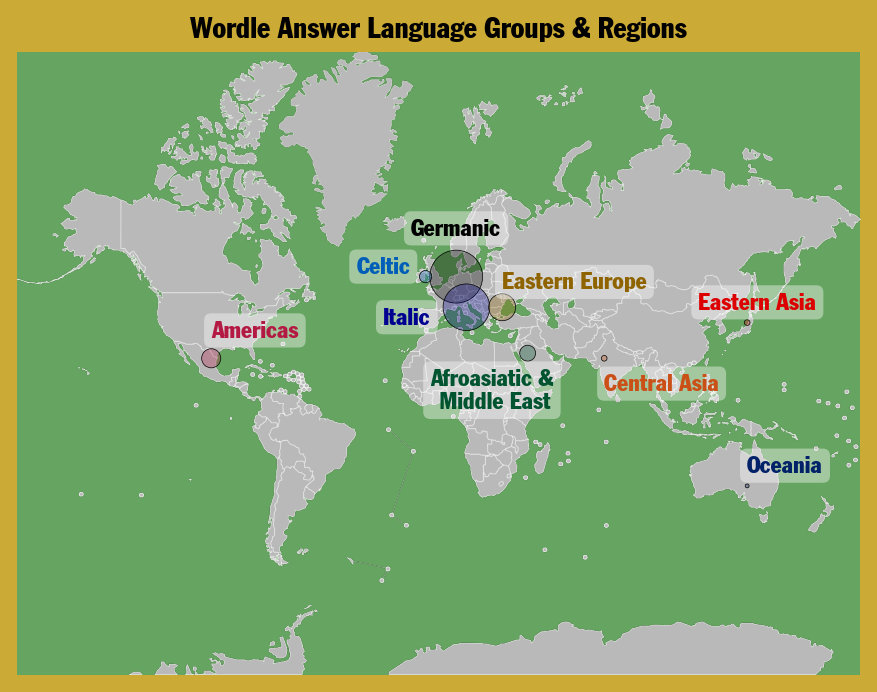

In [39]:
img = mpl.image.imread("../assets/composition/mercator.png")
height, width, *channels = img.shape
g, ax = plt.subplots(dpi=170)
ax.set_facecolor('#66a561')
g.set_facecolor('#cbaa35')
ax.imshow(img)
ax.scatter(LANG_AREA['x'], LANG_AREA['y'], s=LANG_AREA['count']**0.9, 
           c=[mpl.colors.to_rgba(col,alpha=0.3) for col in LANG_AREA['color']], 
           edgecolors="black", linewidths=0.3)
for idx, row in LANG_AREA.iterrows():
    ax.text(row['x'] + row['xoff'], row['y'] + row['yoff'], row['name'], 
            ha=row['hj'], va=row['vj'], fontsize=10, rotation=row['rot'], c=row['color'],
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.4, edgecolor='none'), fontfamily="Franklin Gothic")
    
sns.despine(fig = g, bottom = True, left = True)
plt.title("Wordle Answer Language Groups & Regions", fontfamily="Franklin Gothic")
plt.xticks([])
plt.yticks([])

I like this. Let's save this one to put in my final product.

In [41]:
g.savefig("../assets/elementary_plots/wordle_map.png")
g.savefig("../assets/elementary_plots/wordle_map.svg")